In [1]:
import os
import sys
import pandas as pd
import yaml 
from matplotlib import pyplot as plt

with open("../../config.yaml.local", "r") as f:
    LOCAL_CONFIG = yaml.safe_load(f)
#with open("../../config.yaml", "r") as f:
#    CONFIG = yaml.safe_load(f)
sys.path.append("../python")

import globals

RAW_DATA_PATH = LOCAL_CONFIG["RAW_DATA_PATH"]


In [2]:
users_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "users.parquet"))
item_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "item.parquet"))
itemact_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "itemact.parquet"))
invoice_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "invoice.parquet"))
withdrawal_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "withdrawal.parquet"))
invoiceforward_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "invoiceforward.parquet"))
wallet_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "wallet.parquet"))
walletprotocol_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "walletprotocol.parquet"))


In [3]:
item_df['created_at'] = item_df['created_at'].dt.tz_localize('UTC')

In [4]:
# summary
n_users = len(users_df)
n_items = len(item_df)
first_date = item_df['created_at'].min().strftime('%Y-%m-%d')
last_date = item_df['created_at'].max().strftime('%Y-%m-%d')
print(f"{n_users:,.0f} users, {n_items:,.0f} items from {first_date} to {last_date}")

30,737 users, 1,240,214 items from 2021-06-11 to 2025-10-05


In [5]:
# first autowithdraw date
idx = (withdrawal_df['autoWithdraw']==True) & (withdrawal_df['status']=='CONFIRMED')
autowithdraw_df = withdrawal_df.loc[idx].groupby('userId').agg(
    first_auto_withdraw = ('created_at', 'min')
).reset_index()

In [6]:
# first sent sats date
my_df = itemact_df.merge(
    invoice_df[['id','confirmedAt']].rename(columns={'id':'invoiceId'}),
    how='left', on='invoiceId'
)
idx = (my_df['invoiceId'].notnull()) & (my_df['confirmedAt'].notnull()) & (my_df['act'].isin(['TIP']))
sentsats_df = my_df.loc[idx].groupby('userId').agg(
    first_sent_sats = ('created_at', 'min')
).reset_index()


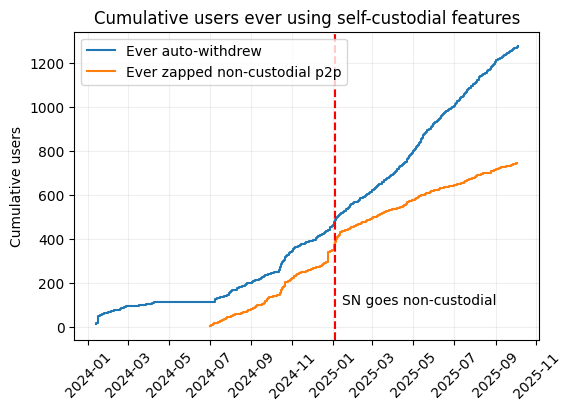

In [30]:
# plot cumulative wallet attaches

plot_df1 = autowithdraw_df['first_auto_withdraw'].dt.date.value_counts().sort_index().cumsum()
plot_df2 = sentsats_df['first_sent_sats'].dt.date.value_counts().sort_index().cumsum()

plt.figure(figsize=(6,4))
plt.step(plot_df1.index, plot_df1.values, where='post', label='Ever auto-withdrew')
plt.step(plot_df2.index, plot_df2.values, where='post', label='Ever zapped non-custodial p2p')
plt.axvline(globals.nc_date, color='red', linestyle='--')
plt.text(globals.nc_date + pd.to_timedelta(10,unit='D'), 100, 'SN goes non-custodial', ha='left')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.ylabel('Cumulative users')
plt.title("Cumulative users ever using self-custodial features")
plt.grid(alpha=0.2)
plt.show()

In [8]:
gtrends_df = pd.read_csv(os.path.join(RAW_DATA_PATH, "google-trends-bitcoin.csv"))
gtrends_df['week_start'] = pd.to_datetime(gtrends_df['week_start'], utc=True)

In [9]:
price_df = pd.read_csv(os.path.join(RAW_DATA_PATH, "coinmarketcap-daily-historical.csv"), delimiter=';')
price_df['date'] = pd.to_datetime(price_df['timeOpen'])
price_df['price_mid'] = (price_df['high'] + price_df['low']) / 2

In [10]:
gtrends_df['price_avg'] = 0.0
gtrends_df['items_raw'] = 0.0
gtrends_df['items'] = 0.0
for idx, row in gtrends_df.iterrows():
    week_start = row['week_start']
    week_end = week_start + pd.to_timedelta(7,unit='D')

    mask = (price_df['date']>=week_start) & (price_df['date']<week_end)
    gtrends_df.at[idx, 'price_avg'] = price_df.loc[mask, 'price_mid'].mean()

    mask = (item_df['created_at']>=week_start) & (item_df['created_at']<week_end)
    items_raw = item_df.loc[mask].shape[0]
    gtrends_df.at[idx, 'items_raw'] = items_raw

    mask = (item_df['created_at']>=week_start) & (item_df['created_at']<week_end) & (item_df['invoiceActionState']!='FAILED') & (item_df['userId']!=globals.spammer_id)
    items = item_df.loc[mask].shape[0]
    gtrends_df.at[idx, 'items'] = items

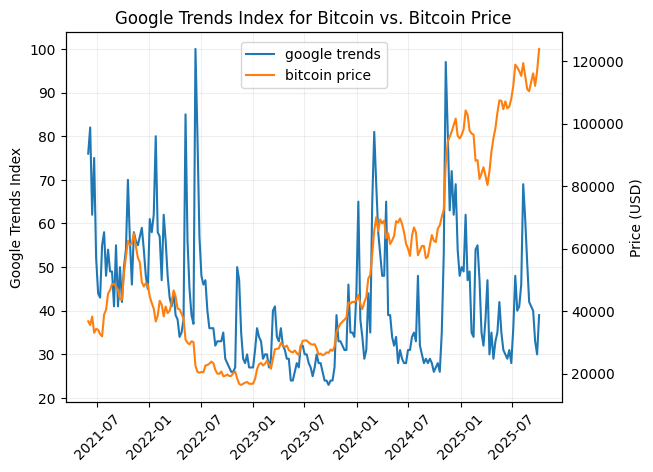

In [22]:
fig, ax1 = plt.subplots()
fig.figsize=(6,4)
ax1.plot(gtrends_df['week_start'], gtrends_df['bitcoin_gtrend'], color='tab:blue', label='google trends')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Google Trends Index')
ax1.grid(alpha=0.2)
ax2 = ax1.twinx()
ax2.plot(gtrends_df['week_start'], gtrends_df['price_avg'], color='tab:orange', label='bitcoin price')
ax2.set_ylabel('Price (USD)')
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.83), bbox_transform=ax1.transAxes, ncol=1)
plt.title("Google Trends Index for Bitcoin vs. Bitcoin Price")
plt.show()

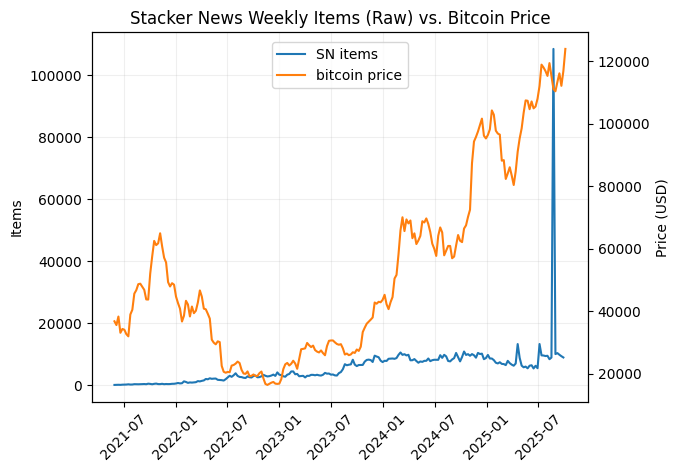

In [24]:
fig, ax1 = plt.subplots()
fig.figsize=(6,4)
ax1.plot(gtrends_df['week_start'][:-1], gtrends_df['items_raw'][:-1], color='tab:blue', label='SN items')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Items')
ax1.grid(alpha=0.2)
ax2 = ax1.twinx()
ax2.set_ylabel('Price (USD)')
ax2.plot(gtrends_df['week_start'], gtrends_df['price_avg'], color='tab:orange', 
label='bitcoin price')
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.83), bbox_transform=ax1.transAxes, ncol=1)
plt.title("Stacker News Weekly Items (Raw) vs. Bitcoin Price")
plt.show()

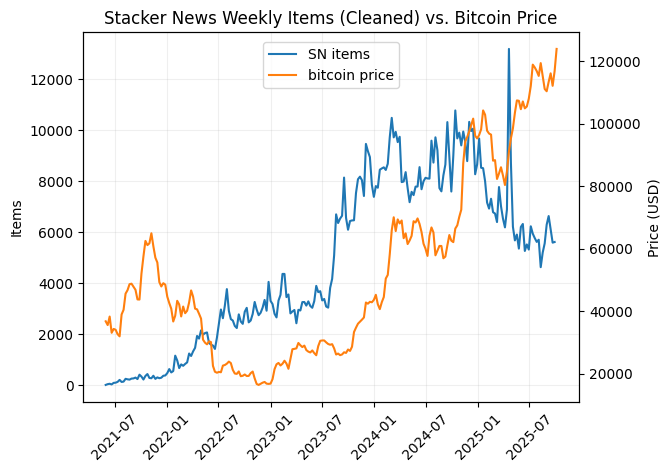

In [25]:
fig, ax1 = plt.subplots()
fig.figsize=(6,4)
ax1.plot(gtrends_df['week_start'][:-1], gtrends_df['items'][:-1], color='tab:blue', label='SN items')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Items')
ax1.grid(alpha=0.2)
ax2 = ax1.twinx()
ax2.plot(gtrends_df['week_start'], gtrends_df['price_avg'], color='tab:orange', label='bitcoin price')
ax2.set_ylabel('Price (USD)')
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.83), bbox_transform=ax1.transAxes, ncol=1)
plt.title("Stacker News Weekly Items (Cleaned) vs. Bitcoin Price")
plt.show()